In [26]:
import matplotlib.pyplot as plt 


from PIL import Image
import torch

import numpy as np
from cipher import *
from scheme import *

from algorithms import Algorithms 
from stats import Statistics

from torchvision import datasets
import torchvision.transforms as transforms

In [16]:
myring = Ring(seed=1234)
parms = Parameters(logp = 30, logq = 500, logn =13)
nslots = 2**(parms.logn-1) # -1? 
context = Context(parms, myring)

sk = context.generate_secret_key()

print(context.params)

keys = {"mult":context.generate_mult_key(),
        "rot":{'1':'hi1',
               '2':'hi2',
               '4':'hi4',
               '8':'hi8'}}
ev = Evaluator(keys, context) # Evaluator도 그냥 context만 넣게 할까? 

encoder = Encoder(context)
encryptor = Encryptor(context)

decryptor = Decryptor(sk)

 logp: 30
 logq: 500 
 logn: 13


FASE 라이브러리 API 함수 이름을 살짝 바꿔가지고 최대한 재활용..

## Original model

In [31]:
import ResNet20
from approximate import approx_relu, approx_sign

activation = lambda x : 40 * approx_relu(x/40, degree = 4, repeat=3)

org_model = ResNet20.ResNet9(activation=activation)


fn_param = "ResNet9avg_minimaxReLU.pt"
trained_param = torch.load(fn_param)
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

In [32]:
org_model

ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (basicblock1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

## load a sample image

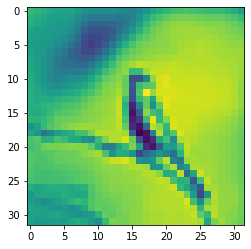

In [35]:
img = np.array(Image.open("./bird6.png"))

# transfrom: normalize to [0,1]
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) 

img_this_example = img_tensor[0] # Assume batch size = 1
img_enc = [encryptor.encrypt(this_channel.ravel()) for this_channel in img_this_example]

dec = decryptor.decrypt(img_enc[0])[:1024]
plt.imshow(dec.reshape(32,32))

## ResNet: 0. early layers

In [ ]:
def convolve_fhe(rotated_ctxt:List, 
                kernel:np.ndarray, 
                sec:SEALContext, 
                pad_masks:List=None,
                eps:float=1e-6,
                ) -> List:
    """
    per-channel convolution.

    params
    ------
    rotated_ctxt: 
        list of rotated ctxts of a channel

    ignores multiplciation with vales less than eps. (assumed to be 0)
    
    NOTE
    ----
    When the input data is normalized [0,1], non-negligible number of weights 
    are smaller than 1e-6.
    """
    if pad_masks is None: pad_masks = [False] * len(rotated_ctxt)

    rkernel = kernel.ravel()
    out_fhe = None
    for rk, rr, mask in zip(rkernel, rotated_ctxt, pad_masks):
        #print("mask", mask)
        if abs(rk) > eps:
            if out_fhe is None:
                out_fhe = sec.multByConst(rr, rk, broadcast=True, rescale=True)
                if mask is not False:
                    mm = np.zeros(int(out_fhe.poly_modulus_degree()/2))
                    mm[:len(mask)] = mask
                    sec.multByConst(out_fhe, mm, inplace=True, rescale=True)
            else:
                tmp = sec.multByConst(rr, rk, broadcast=True, rescale=True)
                if mask is not False:
                    mm = np.zeros(int(tmp.poly_modulus_degree()/2))
                    mm[:len(mask)] = mask
                    sec.multByConst(tmp, mm, inplace=True, rescale=True)
                sec.add(out_fhe, tmp, inplace=True)
                print(sec.decrypt(out_fhe)[:1024])

    return out_fhe

def my_conv2D_FHE(sec:SEALContext, 
                img_enc:List, 
                nh:int, 
                nw:int, 
                convlayer:Conv2d,
                stride_in:int =1, 
                stride_out:int =1, 
                padding:str ="same"):
    """
    
    Convolution between encrypted image and plain kernel

    parameters
    ----------
    sec : Ciphertext
    stride_in: strides that have applied to img_enc so far
    stride_out: stride additionaly applied to img_enc this time
    kernel: conv layer weights from a Pytorch model
    nh: height of the **original** image
    nw: width of the **original** image
    
    Note
    ----
    1. converting a list (of list) to a tensor is 'extremely' slow. 
       So, convert the list to a numpy array first.
    2. strided convolution results in sparse ciphertext. 
       Strides must be tracked to determine value slots of a ctxt.
       It's important to distinguish *strides so far* and the *new stride*.
    """
    kernel = convlayer.weight.detach().numpy()
    bias = convlayer.bias.detach().numpy()

    c_out, c_in, f_h, f_w = kernel.shape
    # e.g., new stride_2 to strided_2 = stride_4
    stride_out *= stride_in
    out_nh, out_nw = get_out_size((nh, nw), (f_h, f_w), 
                                  stride=stride_out, 
                                  padding=padding)
    
    print("Output image size", out_nh, out_nw)
    
    # 3 - > 5, 5 - > 9 , ... 
    dilated_shape = ((f_h-1)*stride_in+1,
                     (f_w-1)*stride_in+1,)
    #dilated_kernel = np.zeros(dilated_shape)

    # Striding by using mask
    mask = np.zeros(int(sec.parms.poly_modulus_degree()/2))
    if stride_out == 1:
        mask[:nw*nh] = np.ones(nw*nh)
    else :
        _mask = np.zeros((nw,nh))
        _mask[::stride_out,::stride_out] = 1.
        mask[:nw*nh] = _mask.ravel()

    #print(mask[:1024].reshape(32,32))
    # padding mask
    pad_masks = gen_pad_mask((f_h, f_w), (nh, nw))

    # rotate each channel
    rotated =[]
    for channel_enc in img_enc:
        #img_aug = aug_ctxt(channel_enc, nh, nw, sec)
        rotated.append(rotate_for_conv(channel_enc, nw, 
                                        dilated_shape[0],
                                        dilated_shape[1], 
                                        sec, 
                                        stride=stride_in))

    ### Main loop ###
    conv_out=[]
    for this_kernel_in_channel, this_bias in zip(kernel, bias):

        # convolve each channel of image and kernel
        result_each_out_channel = None
        for this_channel, this_kernel in zip(rotated, this_kernel_in_channel):
            # 0 - c_in
            if result_each_out_channel == None:
                result_each_out_channel = convolve_fhe(this_channel, this_kernel, sec, pad_masks)
            else:
                sec.add(result_each_out_channel,
                        convolve_fhe(this_channel, this_kernel, sec, pad_masks), inplace=True)
        sec.addConst(result_each_out_channel, this_bias*mask, inplace=True)


        conv_out.append(result_each_out_channel)

    return conv_out, out_nh, out_nw